- TF-IDF : 텍스트 벡터화
- PCA : 차원축소
- LSA : 잠재 의미 분석
- t-SNE : 2D 시각화
- 로지스틱회귀
- 토큰화&전처리

In [ ]:
# LSA
# TF - IDF 행렬에 대해서 SVD
# 단어와 문서 간의 숨겨진 의미 관계를 찾음
# PCA 차이:
    # PCA : 데이터 자체 분산 최대화
    # LSA : 문서-단어형태의 의미구조 파악
# 은행
    # '돈' '계좌'  주변에 등장
    # '나무' '냄새' '먹는다' 주변에 등장

In [ ]:
# t-SNE : 고차원 데이터를 2D,3D로 변환 - 시각화 전용(분석에는 부적합), 계산이 오래걸림
# PCA VS t-SNE
# PCA : 속도가 빠름, 전역 구조 보존
# t-SNE : 느림, 국소(지역)군집 명확

In [7]:
# 데이터셋
from sklearn.datasets import load_files
train_path = r'C:\python_src\LLM\20newsbydate\20news-bydate-train'
test_path = r'C:\python_src\LLM\20newsbydate\20news-bydate-test'
newsgroups_train = load_files(train_path,encoding='latin1')
newsgroups_test = load_files(test_path,encoding='latin1')
categories =  ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
import re

def clean_text(text):
    # 헤더 제거
    text = re.sub(r'^From:.*\n', '', text, flags=re.MULTILINE)
    text = re.sub(r'^Subject:.*\n', '', text, flags=re.MULTILINE)

    # 풋터 제거
    text = re.sub(r'\n--\n.*$', '', text, flags=re.DOTALL)

    # 인용문 제거
    text = re.sub(r'(^|\n)[>|:].*', '', text)

    return text
# 카테고리 제거
def filter_categories(dataset, categories):
    target_names = dataset.target_names
    selected_idx = [ target_names.index(c) for c in categories  ]
    #필터링
    data_filtered, target_filtered = [], []
    for text,label in zip(dataset.data, dataset.target):
        if label in selected_idx:
            new_label = selected_idx.index(label)  # 라벨 재 정렬
            data_filtered.append(text) ; target_filtered.append( new_label  )
    return data_filtered,target_filtered,categories
train_data, train_target, target_names = filter_categories(newsgroups_train,categories)
test_data, test_target, _ = filter_categories(newsgroups_test,categories)

x_train = [ clean_text(t) for t in train_data]
x_test = [ clean_text(t) for t in test_data]
y_train = train_target
y_test = test_target

In [9]:
# 텍스트 전처리 ( 소문자 + 토큰화(3글자이상) + 불용어제거(stopwords) + 어간추출(stemming))  --> 영어
# 파이프라인 
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer  # 같은 의미의 다른형태 단어를 통일
from sklearn.feature_extraction.text import TfidfVectorizer
regtok = RegexpTokenizer(r"[\w']{3,}")
english_stops = set(stopwords.words('english'))
# 커스텀 토크나이져
def tokenizer(text):
    tokens = regtok.tokenize(text)
    words = [word for word in tokens if word not in english_stops]
    features = list(map(lambda x : PorterStemmer().stem(x), words))
    return features
# TF-IDF 벡터화
tfidf = TfidfVectorizer(tokenizer=tokenizer,max_features=2000,min_df=2,max_df=0.5)
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)
# 분류모델
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=200,random_state=42)
lr_clf.fit(x_train_tfidf,y_train)

print('기본분류------------')
print(f'학습정확도 : {lr_clf.score(x_train_tfidf,y_train)}')
print(f'테스트정확도 : {lr_clf.score(x_test_tfidf,y_test)}')

print('주성분분석')
# 데이터의 분산이 가장 큰 방향
# 선형번환만 가능
# 모든 데이터의 특성을 평등하게 고려
# 용도 : 시각화, 속도 개선
# 2000차원 - >100차원축소
from sklearn.decomposition import PCA
pca = PCA(n_components=100,random_state=42)
x_train_pca = pca.fit_transform(x_train_tfidf.toarray())
x_test_pca = pca.transform(x_test_tfidf.toarray())

import numpy as np
cumsum_var =  np.cumsum( pca.explained_variance_ratio_)
print(f'원본 차원 : {x_train_tfidf.shape[1]}')
print(f'축소후 차원 : {x_train_pca.shape[1]}')
print(f'설명된 분산 : {pca.explained_variance_.sum()}')
print(f'누적 분산 : {cumsum_var[:10]}')

# pca 후 분류
lr_clf_pca = LogisticRegression(max_iter=200,random_state=42)
lr_clf_pca.fit(x_train_pca,y_train)

print('주성분 분석 분류------------')
print(f'학습정확도 : {lr_clf_pca.score(x_train_pca,y_train)}')
print(f'테스트정확도 : {lr_clf_pca.score(x_test_pca,y_test)}')

c:\Users\SAMSUNG\anaconda3\envs\deep\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


기본분류------------
학습정확도 : 0.9714847590953786
테스트정확도 : 0.8211382113821138
주성분분석
원본 차원 : 2000
축소후 차원 : 100
설명된 분산 : 0.3282057546167557
누적 분산 : [0.0121115  0.02228287 0.03188107 0.04135532 0.04930669 0.05672712
 0.06348158 0.07011489 0.07655451 0.08263329]
주성분 분석 분류------------
학습정확도 : 0.8987217305801377
테스트정확도 : 0.7945306725794531


In [10]:
# lsa  잠재적 의미분석
# tf-idf svd
# PCA보다 의미론적 관계 잘 포착
# 테스트 데이터에 효과적
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100,random_state=42)
x_train_lsa = svd.fit_transform(x_train_tfidf)
x_test_lsa = svd.transform(x_test_tfidf)

print(f'원본 차원 : {x_train_tfidf.shape[1]}')
print(f'축소후 차원 : {x_train_lsa.shape[1]}')
print(f'설명된 분산 : {svd.explained_variance_.sum()}')

# lsa 후 분류
lr_clf_lsa = LogisticRegression(max_iter=200,random_state=42)
lr_clf_lsa.fit(x_train_lsa,y_train)

print('주성분 분석 분류------------')
print(f'학습정확도 : {lr_clf_lsa.score(x_train_lsa,y_train)}')
print(f'테스트정확도 : {lr_clf_lsa.score(x_test_lsa,y_test)}')

원본 차원 : 2000
축소후 차원 : 100
설명된 분산 : 0.3259753293760355
주성분 분석 분류------------
학습정확도 : 0.895771878072763
테스트정확도 : 0.7945306725794531


In [11]:
# LSA 기반 유사도 분석
# 코사인 유사도  0(완전히 다름) ~ 1(같음)
# LSA 의미기반 유사도
# 첫번재 문서의 유사 문서 찾기
from sklearn.metrics.pairwise import cosine_similarity
sim_result =  cosine_similarity([x_train_lsa[0]], x_train_lsa)
sim_index = (-sim_result[0]).argsort()[:20]
print(f'원문 카테고리 :{newsgroups_train.target_names[y_train[0]]}')
print(f'상위 유사도 : {sorted(sim_result[0],reverse=True)[:5]}')
similar_categorys =  [newsgroups_train.target_names[y_train[i]] for i in sim_index]
print(f'유사 문서들의 카테고리 : {similar_categorys[:10]}')

원문 카테고리 :alt.atheism
상위 유사도 : [np.float64(0.9999999999999997), np.float64(0.8381941969207606), np.float64(0.8279802508840387), np.float64(0.6854434244928551), np.float64(0.6371249120993776)]
유사 문서들의 카테고리 : ['alt.atheism', 'alt.atheism', 'alt.atheism', 'alt.atheism', 'alt.atheism', 'alt.atheism', 'alt.atheism', 'alt.atheism', 'alt.atheism', 'alt.atheism']


In [13]:
# t-sne  2D 시각화
# 고차원 데이터를 2D/3D 변환
# 비슷한 데이터는 가깝게 다른데이터는 멀리 배치
# 계산이 오래 걸리지만 시각화 효과 가 뛰어남
# 주의 : 분석용이 아니라 시각화 전용
from sklearn.manifold import TSNE
# perplexity 이웃개수 조절 
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tnse_lsa = tsne.fit_transform(x_train_lsa)
print(f'입력차원 : {x_train_lsa.shape[1]}')
print(f'출력차원 : {tnse_lsa.shape}')

입력차원 : 100
출력차원 : (2034, 2)


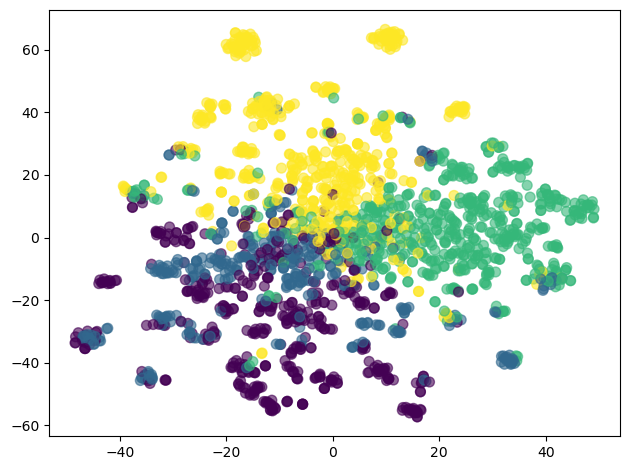

In [17]:
import matplotlib.pyplot as plt
colors = y_train[:len(tnse_lsa)]
plt.scatter(tnse_lsa[:,0],tnse_lsa[:,1],c=colors,cmap='viridis',alpha=0.6, s =50)
plt.tight_layout()
plt.show()

In [ ]:
# TF-IDF (원본 데이터)    
    # 장점 : 해석이 쉽거 정확도가 높음
    # 단점 " 메모리 많이 사용(차원이 높음 -> 차원의 저주)
    # 여도 : 정확도가 우선일 ㅒ

# PCA (선형 차원 축소)
    # 장점 : 계산이 빠르고 간단, 분산 최대 보존
    # 단점 : 선형 변환만 가능
    # 용도 : 속도와 정확도 균형

# LSA (의미 기반 차원 축소
    # 장점 : 의미관계 잘 포착, 유사도 계산에 효과적
    # 단점 : 계산비용 증가
    #   용도 : 문서 유사도, 추천 시스템

# t-SNE (비선형 시각화)
    # 장점 : 군집구조 명확히 보임
    # 단점 : 계산이 오래 걸림, 분석용이 아닌 시각화
    # 용도 : 데이터 탐색 및 이해

텍스트 분류

정확도 최우선               속도 중요 (메모리)          시각화 필요

    TF-IDF                      PCA                         t-SNE

In [18]:
# 한국어 데이터
import pandas as pd
url = "https://drive.google.com/uc?id=1KOKgZ4qCg49bgj1QNTwk1Vd29soeB27o"
df = pd.read_csv(url)

In [ ]:
# 데이터(문장)
# 문장 -> 벡터
    # 문장 - 토큰화
        # 다양한 토크나이저
            # 한글 Okt
                # Okt().pos(문장)
                # 불용어 제거 - 불용어 리스트를 만들어서 stopword 하듯이 제거
    # 토큰 -> 백터화
        # BOW(conterVetotizer)
        # TF-IDF
# 분류모델 선택
# 학습
# 평가         

In [ ]:
# 전처리
# 토크나이저 Okt
# 한글불용어